Training of Detectron2 Model. Based on Detectron2 Tutorial at:
# https://detectron2.readthedocs.io/en/latest/tutorials/getting_started.html
# https://detectron2.readthedocs.io/en/latest/

# Installation of detectron2

In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp310-cp310-linux_x86_64.whl size=44090 sha256=7af152af4951d5d3d1c745e09063fcd58210bb3cc044f4cb8dd548bb9496be12
  Stored in directory: /root/.cache/pip/wheels/70/83/31/975b737609aba39a4099d471d5684141c1fdc3404f97e7f68a
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.12.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
flax 0.7.0 requires PyYAML>=5.4.1, but you have pyyaml 5.1 which is incompatible.
Cloning into 'detectron2'...
remote: Enumerating objects: 15149, done.
remote: Counting objects:

### Check Versions and import required Libraries

In [2]:
# Check versions of detectron and torch
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118
detectron2: 0.6


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import os
import cv2
import numpy as np
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer

### Link colab to Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')
current_directory = '/content/drive/MyDrive/Colab Notebooks/FibreAnalysis/Data'

Mounted at /content/drive


In [11]:
# Optional Step to deregister dataset if it has already been registered ( if modifying dataset while developing )
DatasetCatalog.remove('fibre_Train')
DatasetCatalog.remove('fibre_Val')

### Function to load fibre images 

In [12]:
def get_fibre_dicts(img_dir, mask_dir):
    img_files = os.listdir(img_dir)
    dataset_dicts = []

    for idx, img_file in enumerate(img_files):
        record = {}

        img_path = os.path.join(img_dir, img_file)
        mask_path = os.path.join(mask_dir, f"mask{img_file[5:]}")  # Change filename from image_ to mask _ to retrieve mask

        img = cv2.imread(img_path)
        height, width = img.shape[:2]

        record["file_name"] = img_path
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        mask = cv2.imread(mask_path, 0)  # Load the mask image as grayscale

        # Get contours from mask file to calculate individual masks and bounding boxes 
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        objs = []
        for contour in contours:
            polygon = contour.squeeze().tolist()
            x, y, w, h = cv2.boundingRect(contour)

            if len(polygon) >= 6:  # Ensure at least 3 (x, y) coordinate pairs for a valid polygon - otherwise detectron will kick out error
                obj = {
                    "bbox": cv2.boundingRect(contour),
                    "bbox_mode": BoxMode.XYWH_ABS,
                    "segmentation": [polygon],
                    "category_id": 0,
                }
                objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)

    return dataset_dicts

# Base directory for the Training files 
startDirectory = '/content/drive/MyDrive/Colab Notebooks/FibreAnalysis/Data/Prepared'

for d in ["Train", "Val"]:
    DatasetCatalog.register("fibre_" + d, lambda d=d: get_fibre_dicts(startDirectory + '/' + d + '/images', startDirectory + '/' + d + '/masks'))
    MetadataCatalog.get("fibre_" + d).set(thing_classes=["fibre"])
fibre_metadata = MetadataCatalog.get("fibre_train")

### Check that Dataload will work properly, pick an image and show masks and bounding boxes on it 

{'file_name': '/content/drive/MyDrive/Colab Notebooks/FibreAnalysis/Data/Prepared/Train/images/image_2023-07-15_07-39-13-720954_2.png', 'image_id': 84, 'height': 486, 'width': 707, 'annotations': [{'bbox': (81, 214, 68, 114), 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [[[82, 214], [82, 215], [81, 216], [81, 217], [82, 218], [82, 219], [83, 220], [84, 221], [84, 222], [85, 223], [86, 224], [86, 225], [87, 226], [87, 227], [88, 228], [89, 229], [89, 230], [90, 231], [90, 232], [91, 233], [91, 234], [92, 235], [93, 236], [93, 237], [94, 238], [94, 239], [95, 240], [95, 241], [96, 242], [97, 243], [97, 244], [98, 245], [98, 246], [99, 247], [100, 248], [100, 249], [101, 250], [101, 251], [102, 252], [102, 253], [103, 254], [104, 255], [104, 256], [105, 257], [105, 258], [106, 259], [107, 260], [107, 261], [108, 262], [108, 263], [109, 264], [109, 265], [110, 266], [111, 267], [111, 268], [112, 269], [112, 270], [113, 271], [113, 272], [114, 273], [115, 274], [115, 275], [116, 276]

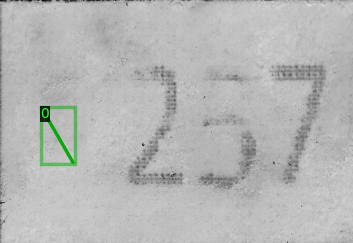

In [30]:
# Display examples with bounding box and masks

fibre_images = '/content/drive/MyDrive/Colab Notebooks/FibreAnalysis/Data/Prepared/Train/images'
fibre_masks = '/content/drive/MyDrive/Colab Notebooks/FibreAnalysis/Data/Prepared/Train/masks'

dataset_fibre_dicts = get_fibre_dicts(fibre_images, fibre_masks)
for d in random.sample(dataset_fibre_dicts, 1):
    print(d)  # Print File name 
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=fibre_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

## Train

Fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the fibre dataset. Plot the training on a tensorboard

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [18]:
cfg = get_cfg()

# cfg.OUTPUT_DIR = "./output"    

cfg.OUTPUT_DIR = "/content/drive/MyDrive/Colab Notebooks/FibreAnalysis/" 

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("fibre_Train",)
cfg.DATASETS.TEST = ("fibre_Val")
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 10001    # Number of training Iterations 
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # The "RoIHead batch size". Region of interest head
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (fibre). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[07/15 17:15:19 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:01, 167MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[07/15 17:15:23 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[07/15 17:15:41 d2.utils.events]:  eta: 0:02:08  iter: 19  total_loss: 2.529  loss_cls: 0.6629  loss_box_reg: 0.2957  loss_mask: 0.6886  loss_rpn_cls: 0.6158  loss_rpn_loc: 0.07627    time: 0.4567  last_time: 0.3194  data_time: 0.0401  last_data_time: 0.0072   lr: 1.6068e-05  max_mem: 2402M
[07/15 17:15:55 d2.utils.events]:  eta: 0:01:54  iter: 39  total_loss: 2.664  loss_cls: 0.513  loss_box_reg: 0.5558  loss_mask: 0.6357  loss_rpn_cls: 0.5651  loss_rpn_loc: 0.11    time: 0.5068  last_time: 0.4082  data_time: 0.0155  last_data_time: 0.0064   lr: 3.2718e-05  max_mem: 2402M
[07/15 17:16:03 d2.utils.events]:  eta: 0:01:44  iter: 59  total_loss: 1.885  loss_cls: 0.4603  loss_box_reg: 0.6928  loss_mask: 0.5351  loss_rpn_cls: 0.1586  loss_rpn_loc: 0.06053    time: 0.4779  last_time: 0.4755  data_time: 0.0097  last_data_time: 0.0054   lr: 4.9367e-05  max_mem: 2455M
[07/15 17:16:12 d2.utils.events]:  eta: 0:01:34  iter: 79  total_loss: 1.5  loss_cls: 0.3464  loss_box_reg: 0.5118  loss_mask: 0

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the fibre validation dataset. First, let's create a predictor using the model we just trained:

In [22]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

# Format of predictions such as masks and shape masks etc. can be found at 
# https://detectron2.readthedocs.io/en/latest/tutorials/models.html#model-output-format

[07/15 17:23:47 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


Then, we randomly select several samples to visualize the prediction results.

{'file_name': '/content/drive/MyDrive/Colab Notebooks/FibreAnalysis/Data/Prepared/Val/images/image_2023-07-15_07-39-42-181540_1.png', 'image_id': 2, 'height': 490, 'width': 714, 'annotations': [{'bbox': (613, 390, 101, 28), 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [[[613, 390], [613, 391], [613, 392], [613, 393], [614, 393], [615, 393], [616, 394], [617, 394], [618, 394], [619, 394], [620, 395], [621, 395], [622, 395], [623, 396], [624, 396], [625, 396], [626, 396], [627, 396], [628, 397], [629, 397], [630, 397], [631, 397], [632, 398], [633, 398], [634, 398], [635, 399], [636, 399], [637, 399], [638, 399], [639, 399], [640, 400], [641, 400], [642, 400], [643, 400], [644, 401], [645, 401], [646, 401], [647, 401], [648, 402], [649, 402], [650, 402], [651, 402], [652, 403], [653, 403], [654, 403], [655, 403], [656, 404], [657, 404], [658, 404], [659, 404], [660, 405], [661, 405], [662, 405], [663, 405], [664, 405], [665, 406], [666, 406], [667, 406], [668, 407], [669, 407], [6

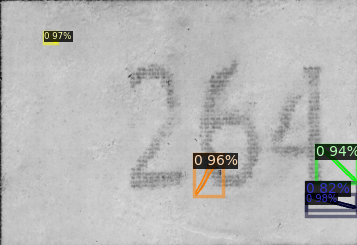

{'file_name': '/content/drive/MyDrive/Colab Notebooks/FibreAnalysis/Data/Prepared/Val/images/image_2023-07-15_07-39-49-203141_1.png', 'image_id': 17, 'height': 490, 'width': 711, 'annotations': [{'bbox': (242, 274, 210, 91), 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [[[445, 274], [444, 275], [443, 275], [442, 276], [441, 276], [440, 277], [439, 277], [438, 278], [437, 278], [436, 279], [435, 279], [434, 280], [433, 280], [432, 281], [431, 281], [430, 281], [429, 282], [428, 282], [427, 283], [426, 283], [425, 284], [424, 284], [423, 285], [422, 285], [421, 285], [420, 286], [419, 286], [418, 286], [417, 287], [416, 287], [415, 288], [414, 288], [413, 289], [412, 289], [411, 290], [410, 290], [409, 291], [408, 291], [407, 292], [406, 292], [405, 293], [404, 293], [403, 294], [402, 294], [401, 295], [400, 295], [399, 296], [398, 296], [397, 297], [396, 297], [395, 297], [394, 298], [393, 298], [392, 299], [391, 299], [390, 299], [389, 300], [388, 300], [388, 301], [387, 302], [

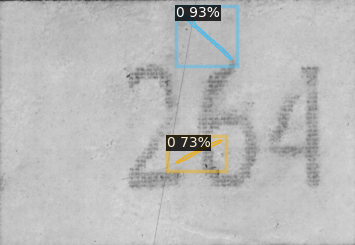

{'file_name': '/content/drive/MyDrive/Colab Notebooks/FibreAnalysis/Data/Prepared/Val/images/image_2023-07-15_07-39-52-493548_1.png', 'image_id': 27, 'height': 948, 'width': 714, 'annotations': [{'bbox': (81, 671, 82, 30), 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [[[160, 671], [159, 672], [158, 672], [157, 672], [156, 672], [155, 673], [154, 673], [153, 673], [152, 674], [151, 674], [150, 674], [149, 674], [148, 675], [147, 675], [146, 675], [145, 675], [144, 676], [143, 676], [142, 676], [141, 677], [140, 677], [139, 678], [138, 678], [137, 678], [136, 679], [135, 679], [134, 679], [133, 679], [132, 680], [131, 680], [130, 680], [129, 681], [128, 681], [127, 681], [126, 682], [125, 682], [124, 682], [123, 683], [122, 683], [121, 684], [120, 684], [119, 684], [118, 685], [117, 685], [116, 685], [115, 686], [114, 686], [113, 686], [112, 687], [111, 687], [110, 687], [109, 688], [108, 688], [107, 688], [106, 689], [105, 689], [104, 690], [103, 690], [102, 690], [101, 691], [10

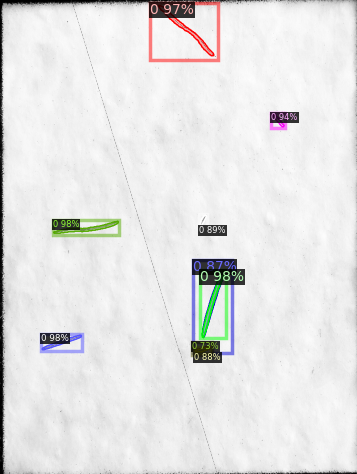

In [31]:
from detectron2.utils.visualizer import ColorMode

dataset_dicts = get_fibre_dicts(startDirectory + '/Val/images', startDirectory + '/Val/masks')

for d in random.sample(dataset_dicts, 3):
    print(d)
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=fibre_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

Evaluate its performance using AP metric implemented in COCO API.

In [27]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
#evaluator = COCOEvaluator("fibre_Val", output_dir="./output")
evaluator = COCOEvaluator("fibre_Val", output_dir=cfg.OUTPUT_DIR)

val_loader = build_detection_test_loader(cfg, "fibre_Val")

# Create a predictor using the trained model
predictor = DefaultPredictor(cfg)

print(inference_on_dataset(predictor, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[07/15 17:46:32 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.


FileNotFoundError: ignored

In [29]:
# Evaluate the model
eval_results = trainer.test(cfg, trainer.model)

print(eval_results)

OrderedDict()
